# Creating Artificial Skull and Brain Models

This notebook warps a model of a real skull to create artificial skull models that resemble real ones. These can be used in wavefield simulations to create training and testing data for the prediction of wavefield borders. 

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/ML_Ultrasound_Project/UROPdata

/content/drive/My Drive/ML_Ultrasound_Project/UROPdata


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math, copy, random, pprint
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import MinMaxScaler
import cv2

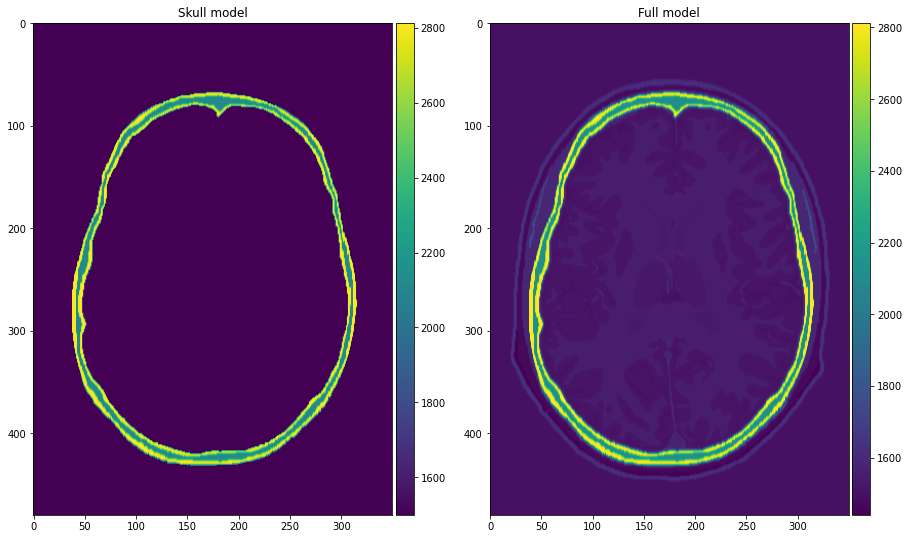

In [6]:
# # Load different types of background models
water_model = np.ones((480, 350)) * 1500.

raw_skull_model = np.fromfile('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/data/alpha2D-ExactSkull.raw', dtype=np.float32, count=-1)
skull_model = raw_skull_model.reshape([350, 480])[::1, ::1].transpose()

raw_full_model = np.fromfile('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/data/alpha2D-TrueVp.raw', dtype=np.float32, count=-1)
full_model = raw_full_model.reshape([350, 480])[::1, ::1].transpose()

y_length = 480+66+4  #480+11
x_length = 350+66+4  #350+11

# Define a physical size
shape = (y_length, x_length)
    
spacing = (0.5e-3, 0.5e-3)      # Grid spacing in m.
origin = (0., 0.)               # What is the location of the top left corner. This is necessary to define
                                # the absolute location of the source and receivers

# Define a velocity profile. The velocity is in m/s
diff_x = shape[0] - skull_model.shape[0]
diff_y = shape[1] - skull_model.shape[1]
offset_x = int(np.floor(diff_x/2))
offset_y = int(np.floor(diff_y/2))

fig, ax = plt.subplots(1,2, figsize=(15,10))
divider = make_axes_locatable(ax[0])
cax0 = divider.append_axes("right", size="5%", pad=0.05)
ax[0].set_title('Skull model')
im0 = ax[0].imshow(skull_model)
fig.colorbar(im0, cax=cax0)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
ax[1].set_title('Full model')
im1 = ax[1].imshow(full_model)
fig.colorbar(im1, cax=cax1)

plt.show()

In [9]:
def warp_skull(src, pts_src, pts_dst):

    # Compute the perspective transform matrix for the points
    ph, _ = cv2.findHomography(pts_src, pts_dst)

    # Find the corners after the transform has been applied
    height, width = src.shape[:2]
    corners = np.array([
      [0, 0],
      [0, height - 1],
      [width - 1, height - 1],
      [width - 1, 0]
    ])
    corners = cv2.perspectiveTransform(np.float32([corners]), ph)[0]

    # Find the bounding rectangle
    bx, by, bwidth, bheight = cv2.boundingRect(corners)

    # Compute the translation homography that will move (bx, by) to (0, 0)
    th = np.array([
      [ 1, 0, -bx ],
      [ 0, 1, -by ],
      [ 0, 0,   1 ]
    ])

    # Combine the homographies
    pth = ph.dot(th)

    # Apply the transformation to the image
    return cv2.warpPerspective(src, pth, (bwidth, bheight), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT)

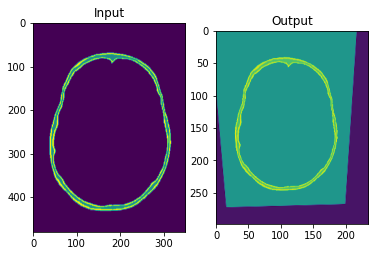

In [10]:
src = copy.deepcopy(skull_model)
pts_src = np.float32([[56,65],[368,52],[28,387],[389,390]])
# pts_dst = np.float32([[0,0],[300,0],[0,300],[300,300]])
pts_dst = np.float32([[0,0],[200,0],[0,200],[200,200]])
warped = warp_skull(src, pts_src, pts_dst)
plt.subplot(121),plt.imshow(src),plt.title('Input')
plt.subplot(122),plt.imshow(warped),plt.title('Output')
plt.show()

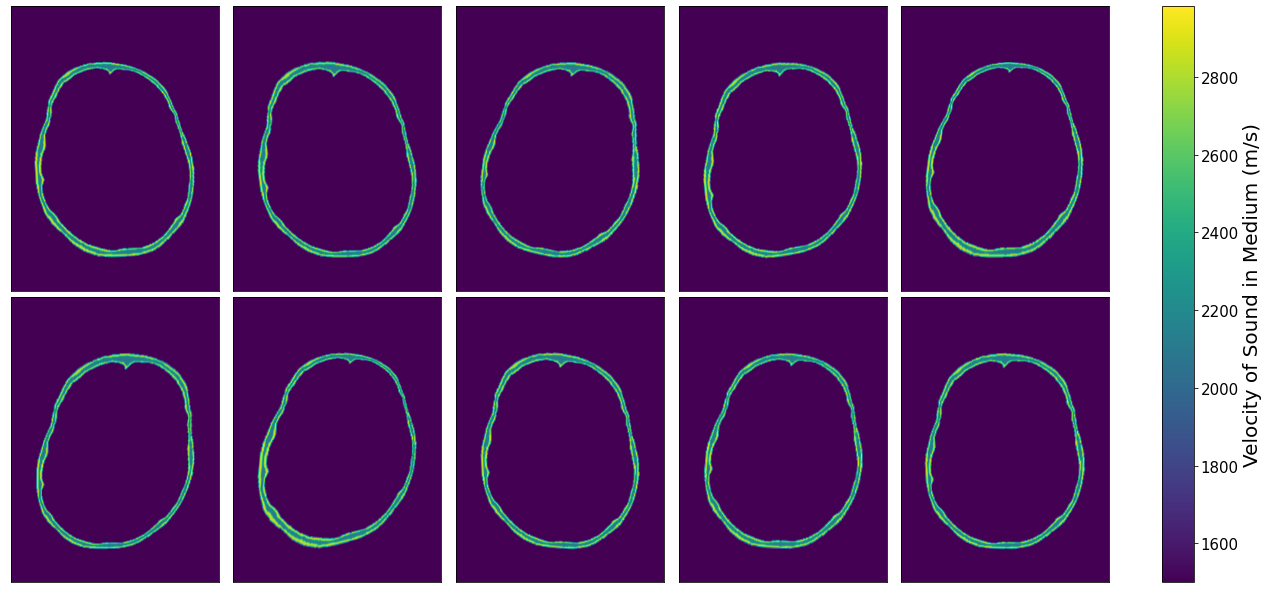

In [11]:
num_models = 10
dsize = (270, 330)

skulls = []

for i in range(num_models):

  # Change the randint ranges below to determine how much the skulls are warped
  t = np.random.randint(0, 100, size=4)
  b = np.random.randint(380, skull_model.shape[0], size=4)
  v = np.random.randint(250, skull_model.shape[1])
  
  pts_src = np.float32([[t[0],t[1]],[b[0],t[2]],[t[3],b[1]],[b[2],b[3]]])
  pts_dst = np.float32([[0,0],[v,0],[0,v],[v,v]])

  warped = warp_skull(src, pts_src, pts_dst)
  warped[np.where(warped < 1500)] = 1500

  # Call cv2.findContours
  scaler = MinMaxScaler(feature_range=[0,255])
  scaled = scaler.fit_transform(warped)
  warped = np.array(scaled, dtype = np.uint8)
  descaled = scaler.inverse_transform(warped)
  
  # Crop to skull
  contours,_ = cv2.findContours(warped, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)
  x,y,w,h= cv2.boundingRect(sorted_contours[0])
  warped = descaled[y:y+h, x:x+w]

  # Resize image
  warped = cv2.resize(warped, dsize)
  warped = cv2.copyMakeBorder(warped, 95, 55, 40, 40, cv2.BORDER_CONSTANT, value=1500)

  skulls.append(warped)

fig, axs = plt.subplots(2, 5, figsize=(22,10))
k = 0
for ax in axs.flat:
    img = ax.imshow(skulls[k])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(warped)
    k+=1
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(img, cax=cb_ax)
cbar.ax.set_ylabel('Velocity of Sound in Medium (m/s)', fontsize=20)
cbar.ax.tick_params(labelsize=15)
plt.show()

In [ ]:
# np.save('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/data/fakeSkulls', skulls)

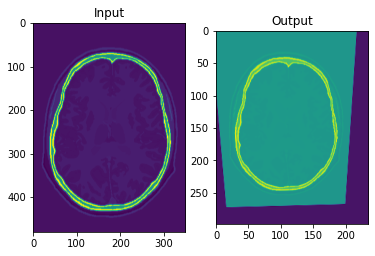

In [12]:
src = copy.deepcopy(full_model)
pts_src = np.float32([[56,65],[368,52],[28,387],[389,390]])
# pts_dst = np.float32([[0,0],[300,0],[0,300],[300,300]])
pts_dst = np.float32([[0,0],[200,0],[0,200],[200,200]])
warped = warp_skull(src, pts_src, pts_dst)
plt.subplot(121),plt.imshow(src),plt.title('Input')
plt.subplot(122),plt.imshow(warped),plt.title('Output')
plt.show()

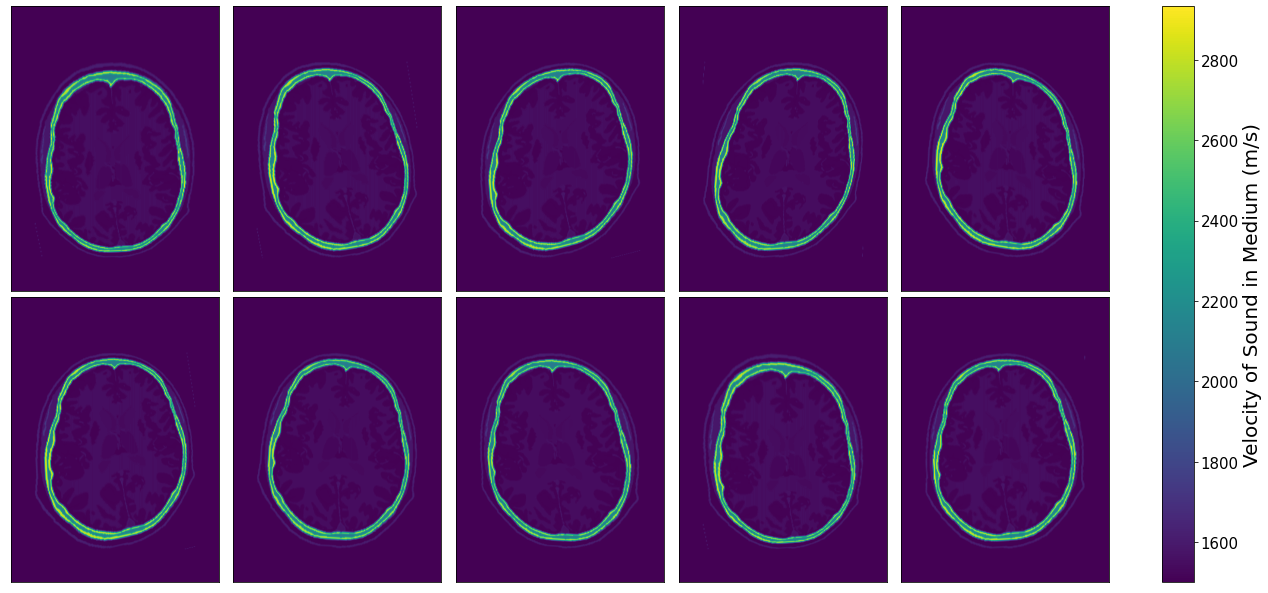

In [15]:
num_models = 10
dsize = (270, 330)

skulls = []

for i in range(num_models):
  
  # Change the randint ranges below to determine how much the skulls are warped
  t = np.random.randint(0, 100, size=4)
  b = np.random.randint(380, skull_model.shape[0], size=4)
  v = np.random.randint(250, skull_model.shape[1])
  
  pts_src = np.float32([[t[0],t[1]],[b[0],t[2]],[t[3],b[1]],[b[2],b[3]]])
  pts_dst = np.float32([[0,0],[v,0],[0,v],[v,v]])

  warped = warp_skull(src, pts_src, pts_dst)
  warped[np.where(warped < 1500)] = 1500

  # Call cv2.findContours
  scaler = MinMaxScaler(feature_range=[0,255])
  scaled = scaler.fit_transform(warped)
  warped = np.array(scaled, dtype = np.uint8)
  descaled = scaler.inverse_transform(warped)
  
  # Crop to skull
  contours,_ = cv2.findContours(warped, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)
  x,y,w,h= cv2.boundingRect(sorted_contours[0])
  warped = descaled[y:y+h, x:x+w]

  # Resize image
  warped = cv2.resize(warped, dsize)
  warped = cv2.copyMakeBorder(warped, 95, 55, 40, 40, cv2.BORDER_CONSTANT, value=1500)

  skulls.append(warped)

fig, axs = plt.subplots(2, 5, figsize=(22,10))
k = 0
for ax in axs.flat:
    img = ax.imshow(skulls[k])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(warped)
    k+=1
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(img, cax=cb_ax)
cbar.ax.set_ylabel('Velocity of Sound in Medium (m/s)', fontsize=20)
cbar.ax.tick_params(labelsize=15)
plt.show()

In [ ]:
# np.save('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/data/fakeBrains', skulls)